# DOG CAT PROJECT

### READ IMAGES

In [1]:
import io
import os
import numpy as np
from PIL import Image
from pymongo import MongoClient
import gridfs
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd
import seaborn as sns

##### Connect to MongoD

In [2]:
client = MongoClient("mongodb://localhost:27017/")
db = client['pet_images_db']
fs = gridfs.GridFS(db)

##### get images from mongo

In [3]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['pet_images_db']
fs = gridfs.GridFS(db)

# Function to fetch images and labels as NumPy arrays
def load_images_and_labels():
    images = []
    labels = []

    for file in fs.find():  # Iterate over all files in GridFS
        try:
            # Check if metadata exists and get the label
            if file.metadata is None or 'label' not in file.metadata:
                print(f"Skipping file {file.filename}: Missing metadata or label.")
                continue

            label = file.metadata['label']  # Either 'cat' or 'dog'

            # Read the image data
            image_data = file.read()

            # Convert binary data to a PIL image
            image = Image.open(io.BytesIO(image_data)).convert("RGB")

            # Resize image to a fixed size (e.g., 128x128) for model compatibility
            image = image.resize((128, 128))

            # Convert image to a NumPy array
            image_array = np.array(image)

            # Append image and label to lists
            images.append(image_array)
            labels.append(0 if label == 'cat' else 1)  # Use 0 for cats, 1 for dogs
        except Exception as e:
            print(f"Failed to process file {file.filename}: {e}")

    return np.array(images), np.array(labels)

# Fetch images and labels
X, y = load_images_and_labels()

/Users/mahdi/PycharmProjects/.venv/DogCat/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Failed to process file Thumbs.db: cannot identify image file <_io.BytesIO object at 0x16bb685e0>
Failed to process file 666.jpg: cannot identify image file <_io.BytesIO object at 0x16bb685e0>
Failed to process file Thumbs.db: cannot identify image file <_io.BytesIO object at 0x16b57ddf0>
Failed to process file 11702.jpg: cannot identify image file <_io.BytesIO object at 0x16b5e56c0>


##### show 25 sample from dataset

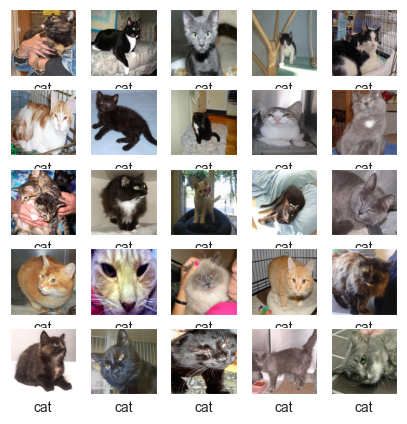

In [4]:
class_names = ['cat', 'dog']

plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel('cat' if y[i] == 0 else 'dog')
plt.show()

##### make sequential model

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

/Users/mahdi/PycharmProjects/.venv/DogCat/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,268,309 (12.47 MB)

 Trainable params: 3,268,309 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

###### split dataset to train and test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, 
                    validation_data=(X_test, y_test))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 205s 163ms/step - accuracy: 0.7451 - loss: 1.5986 - val_accuracy: 0.7579 - val_loss: 0.5646
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 215s 172ms/step - accuracy: 0.7443 - loss: 0.5718 - val_accuracy: 0.7579 - val_loss: 0.5542
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 209s 168ms/step - accuracy: 0.7504 - loss: 0.5620 - val_accuracy: 0.7579 - val_loss: 0.5539
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 162ms/step - accuracy: 0.7496 - loss: 0.5628 - val_accuracy: 0.7579 - val_loss: 0.5539
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 199s 159ms/step - accuracy: 0.7530 - loss: 0.5591 - val_accuracy: 0.7579 - val_loss: 0.5538


313/313 - 12s - 38ms/step - accuracy: 0.7579 - loss: 0.5538


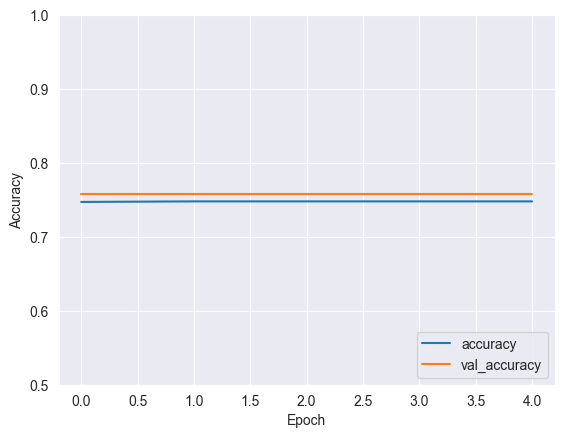

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

##### preprocess image to make predict

In [12]:
def preprocess_image(image_path):
    """
    Preprocess an image for prediction.
    Args:
        image_path (str): Path to the image file.
    Returns:
        np.ndarray: Preprocessed image array.
    """
    img = Image.open(image_path).convert("RGB")
    img = img.resize((128, 128))  # Match the model's input size
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [117]:
def predict_label(image_path, model):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)[0][0]  # Raw probability output

    print(f"Raw prediction output: {prediction}")  # Debugging step

    # Interpret the result
    return "dog" if prediction > 0.5 else "cat"

In [118]:
images_path = ["./images.jpg", "./images2.jpg", "./images3.jpeg", "./images4.jpg"]
for image_path in images_path:
    label = predict_label(image_path, model)
    print(f"The predicted label for the image is: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Raw prediction output: 0.2532941997051239
The predicted label for the image is: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Raw prediction output: 0.2532941997051239
The predicted label for the image is: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Raw prediction output: 0.2532941997051239
The predicted label for the image is: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Raw prediction output: 0.2532941997051239
The predicted label for the image is: cat
